# HCP Hybrid Recommender System using LSTM

This notebook develops a **Hybrid Recommendation System** for **Healthcare Professionals (HCPs)** to predict the **Next Best Content (NBC)** and **Next Best Channel (NBC)** — enabling data-driven, personalized engagement strategies in the pharmaceutical domain.

---

### Objective
To create a recommender system that intelligently suggests the most relevant scientific content to each HCP by combining **behavioral patterns**, **content similarity**, and **temporal engagement dynamics**.

---

### Key Components
1. **Collaborative Filtering**  
   - Learns from historical engagement data between HCPs and content (views, clicks, dwell time).  
   - Captures collective behavior patterns — “HCPs with similar interests consume similar content.”

2. **Content-Based Filtering**  
   - Uses **text/topic embeddings** (e.g., LDA) and content metadata.  
   - Understands the scientific meaning and context of each content piece.

3. **Sequential Modeling (LSTM)**  
   - The **LSTM layer** models time-dependent engagement sequences.  
   - Helps the model learn how content consumption evolves over time.

4. **Hybrid Fusion Layer**  
   - Combines collaborative and content-based signals using weighted fusion or a neural network architecture.  
   - Produces personalized **Top-N Content** and **Next Best Channel** recommendations.

---

### System Architecture Overview
The workflow integrates data from:
- **HCP demographics and specializations**
- **Engagement logs** (e.g., click-throughs, dwell time)
- **Content metadata and embeddings**

These are transformed into engineered features (interaction matrices, embeddings, encodings) and fed into the **Hybrid LSTM-based Model**, which outputs:
- **Top-N Recommended Content**
- **Next Best Channel** for engagement.

---

#### Step 1 : Importing Libraries

In this step, import all the required libraries for building and training our hybrid deep learning recommendation model.

- **Data manipulation**: pandas, numpy
- **Text processing**: gensim, CountVectorizer, TfidfVectorizer
- **Machine learning utilities**: train_test_split, OneHotEncoder, LabelEncoder, evaluation metrics
- **Deep learning**: TensorFlow and Keras modules for building multi-input neural networks
- **Reproducibility**: Setting random seeds ensures stable and consistent results across runs

This step sets up the environment for the entire modeling pipeline.

In [1]:
import random
import numpy as np
import pandas as pd
import gensim
import tqdm
import os, json, pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

---

#### Step 2 : Loading Preprocessed Datasets

- *scientific_content_df*: Contains metadata and textual information (Title, Abstract, LDA topics) about scientific articles.
- *hcp_interaction_df*: Contains engagement data between healthcare professionals (HCPs) and content, such as clicks, reads, or opens.

Each interaction is labeled with engagement_label, representing whether an HCP engaged with that content — **target variable** for supervised learning.

By linking content and interaction data, a relational foundation for a hybrid recommendation engine is created.

In [3]:
# Loading Preprocessed scientific_content_df and hcp_interaction_df

scientific_content_df = pd.read_csv("C:/Users/bhand/Desktop/Data Science - My Collection/Deep Learning Project - 1/Data/Data for Recommender System/HCP_Hybrid_Recommendation_System/data/scientific_content.csv")
hcp_interaction_df = pd.read_csv("C:/Users/bhand/Desktop/Data Science - My Collection/Deep Learning Project - 1/Data/Data for Recommender System/HCP_Hybrid_Recommendation_System/data/hcp_interaction_data.csv")

print(scientific_content_df.shape, hcp_interaction_df.shape)
print(scientific_content_df.head())
print(hcp_interaction_df.head())

(509, 18) (321556, 13)
       PMID                                              Title  \
0  40887509  Sodium glucose co-transporter 2 inhibitor-asso...   
1  40886230  Can Dual Incretin Receptor Agonists Exert Bett...   
2  40885915  The association between diabetes management se...   
3  40884731  Intrinsic Motivation Moderates the Effect of F...   
4  40877913  Inhibitory effects of the flavonoids extracted...   

                                            Abstract  topic_ids  \
0  Perioperative euglycaemic diabetic ketoacidosi...          9   
1  Despite advances in cardiovascular risk reduct...          5   
2  Self-efficacy emerges as a crucial element tha...          1   
3  Few studies have examined effects of intrinsic...          0   
4  Pollen Typhae (PT), a traditional Chinese medi...          7   

                                      topic_keywords content_id  source  \
0  group, control, risk, cardiovascular, disease,...      C0000  PubMed   
1  management, diabetes, gl

---

#### Step 3 : Exploratory Data Analysis (EDA)

Before building the model, it’s crucial to understand the dataset and HCP engagement patterns.  
EDA helps us uncover:

- Class imbalance in engagement labels
- Distribution of content across topics and channels
- HCP specialization coverage
- Relationships between features and engagement probability

This step ensures we are informed about **data quality, patterns, and potential preprocessing needs**.
The dataset’s class imbalance is retained to reflect real-world HCP engagement behavior. Balancing techniques were avoided since they distorted genuine interaction patterns and reduced model calibration and validation performance.

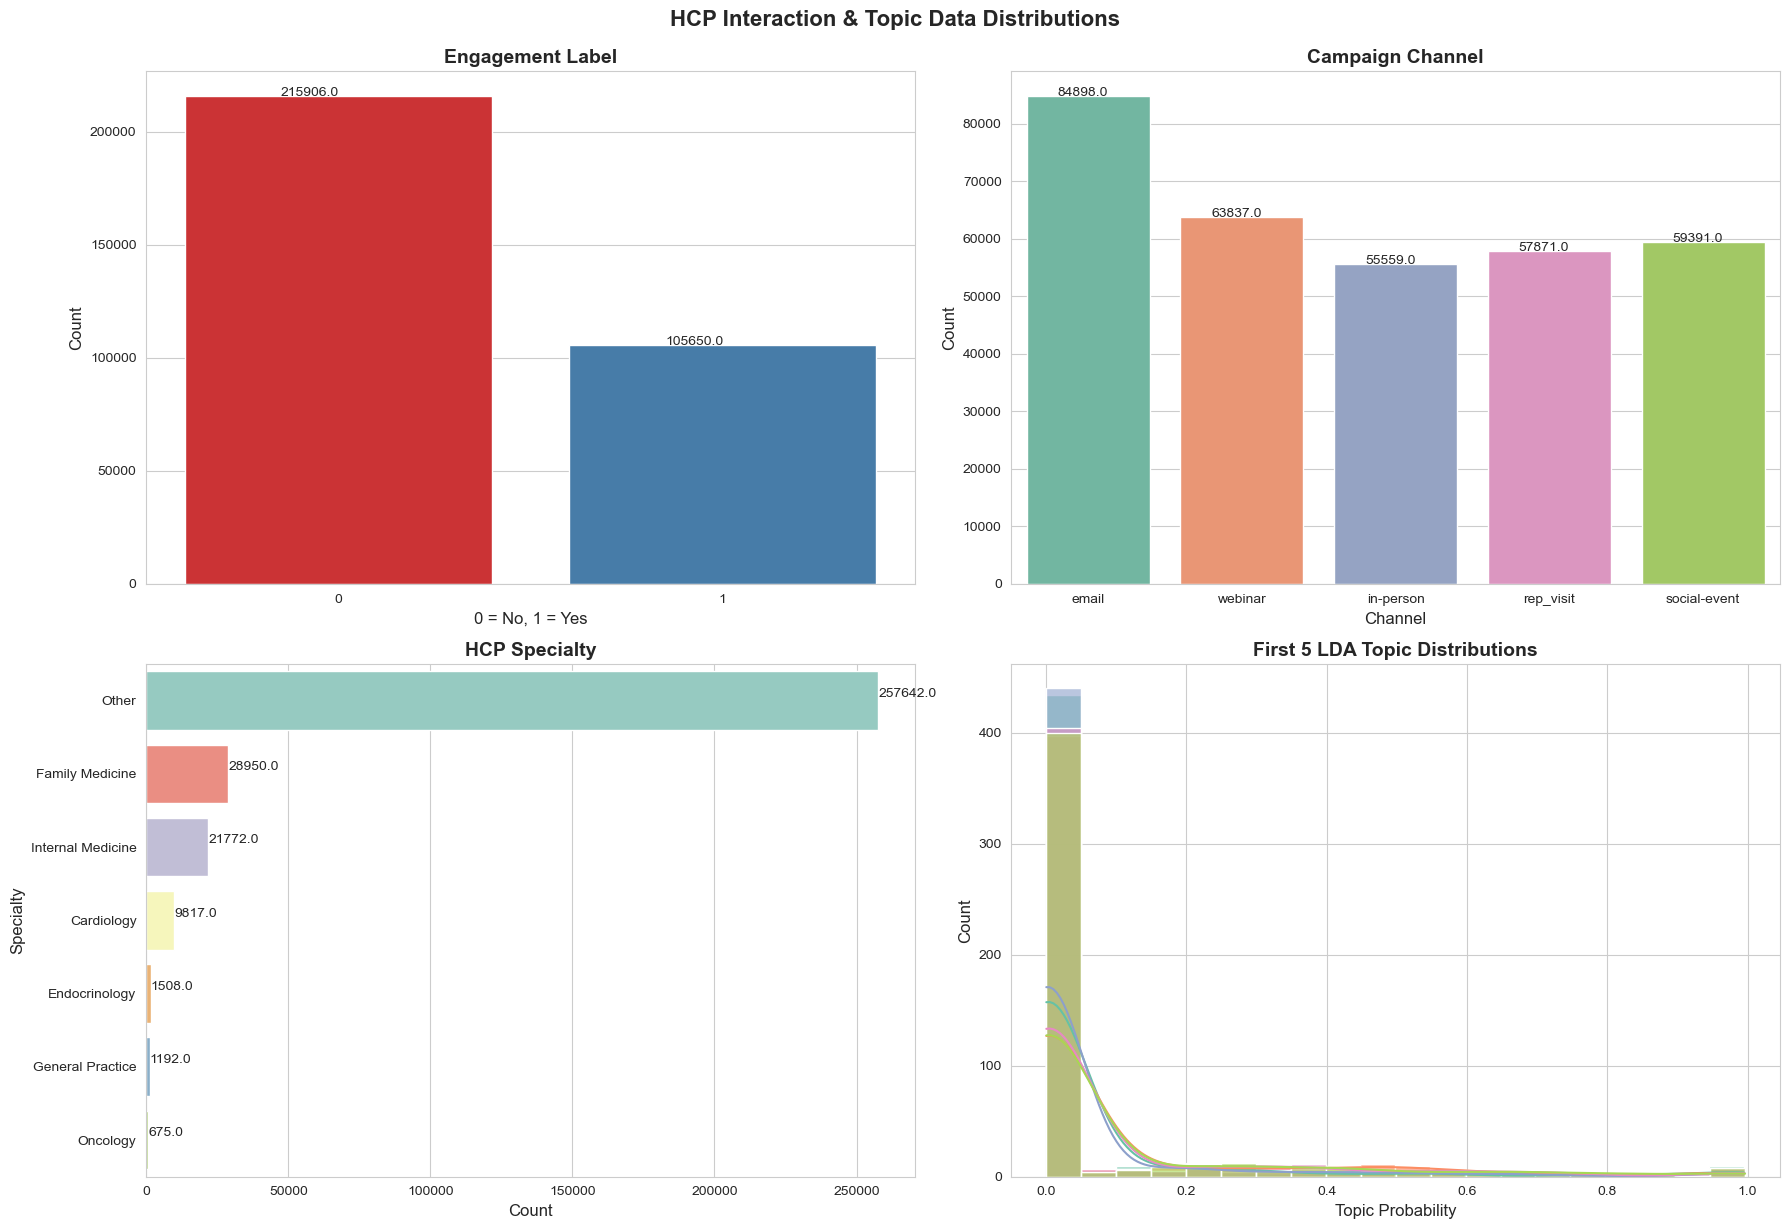

In [4]:
# Set a polished style
sns.set_style("whitegrid")
sns.set_palette("Set2")

fig, axes = plt.subplots(2, 2, figsize=(18,12))
axes = axes.flatten()  # easier indexing

# ---------------- Engagement Label ----------------
ax = axes[0]
sns.countplot(x='engagement_label', data=hcp_interaction_df, palette="Set1", hue='engagement_label', legend=False, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.25, p.get_height()+5))
ax.set_title('Engagement Label', fontsize=14, fontweight='bold')
ax.set_xlabel('0 = No, 1 = Yes', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# ---------------- Campaign Channel ----------------
ax = axes[1]
sns.countplot(x='campaign_channel', data=hcp_interaction_df, palette="Set2", hue='campaign_channel', legend=False, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x()+0.2, p.get_height()+2))
ax.set_title('Campaign Channel', fontsize=14, fontweight='bold')
ax.set_xlabel('Channel', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# ---------------- HCP Specialty ----------------
ax = axes[2]
sns.countplot(y='hcp_specialty', data=hcp_interaction_df, 
              order=hcp_interaction_df['hcp_specialty'].value_counts().index,
              palette="Set3", hue='hcp_specialty', legend=False, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width()+5, p.get_y()+0.35))
ax.set_title('HCP Specialty', fontsize=14, fontweight='bold')
ax.set_xlabel('Count', fontsize=12)
ax.set_ylabel('Specialty', fontsize=12)

# ---------------- Sample LDA Topic Distributions ----------------
ax = axes[3]
topic_cols = [c for c in scientific_content_df.columns if c.startswith('topic_')]
colors = sns.color_palette("Set2", n_colors=5)

for i, col in enumerate(topic_cols[2:7]):
    sns.histplot(
        scientific_content_df[col],
        bins=20,
        kde=True,
        color=colors[i],
        hue=None,
        legend=False,
        ax=ax,
        alpha=0.6
    )

ax.set_title('First 5 LDA Topic Distributions', fontsize=14, fontweight='bold')
ax.set_xlabel('Topic Probability', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

plt.tight_layout()
plt.suptitle('HCP Interaction & Topic Data Distributions', fontsize=16, fontweight='bold', y=1.02)
plt.show()

#### Step 3 : Preparing LDA Topic Features

Extract columns beginning with topic_ — these represent the **document-topic probability distributions** obtained from Latent Dirichlet Allocation (LDA).

Each scientific article is now numerically described as a vector of topic probabilities.
*For example, if there are 15 topics, each article has a 15-dimensional topic vector indicating how much it relates to each theme.*

These features serve as **semantic representations** of the articles, enabling the model to understand underlying content themes beyond raw text.

In [22]:
# Prepare LDA Topic Features
topic_cols = [col for col in scientific_content_df.columns if col.startswith("topic_")]
for col in topic_cols:
    scientific_content_df[col] = pd.to_numeric(scientific_content_df[col], errors='coerce').fillna(0.0)
lda_feats_all = scientific_content_df[topic_cols].values

n_topics = len(topic_cols)

# Viewing topic_cols structure and datatype
print(scientific_content_df[topic_cols].head())
print(scientific_content_df[topic_cols].dtypes)

   topic_ids  topic_keywords   topic_0   topic_1   topic_2   topic_3  \
0          9             0.0  0.000400  0.000584  0.205027  0.000507   
1          5             0.0  0.000440  0.000642  0.000446  0.000558   
2          1             0.0  0.001692  0.532260  0.448801  0.002145   
3          0             0.0  0.546629  0.271952  0.000572  0.000716   
4          7             0.0  0.209126  0.004637  0.003217  0.004026   

    topic_4   topic_5   topic_6   topic_7   topic_8   topic_9  
0  0.000541  0.129902  0.187374  0.000603  0.000469  0.474591  
1  0.000595  0.994736  0.000650  0.000663  0.000516  0.000755  
2  0.002287  0.002878  0.002498  0.002551  0.001984  0.002904  
3  0.000763  0.000960  0.175925  0.000851  0.000662  0.000969  
4  0.004293  0.366418  0.004689  0.394418  0.003725  0.005451  
topic_ids           int64
topic_keywords    float64
topic_0           float64
topic_1           float64
topic_2           float64
topic_3           float64
topic_4           float64
t

#### Step 4 : Text Tokenization and Sequence Preparation

In this step, free text (Title + Abstract)is converted into numerical sequences suitable for neural networks.

- The **Title** and **Abstract** are concatenated to form a single text field.
- Keras’ Tokenizer transforms each word into an integer index (vocabulary capped at 20,000 words).

pad_sequences ensures all text inputs have a fixed length of 150 tokens.

This preprocessed sequence data is fed into an **LSTM layer**, which learns contextual and sequential dependencies between words, forming a **deep semantic embedding** of the **scientific text**.

Statistically, this captures linguistic structure and content meaning, similar to what Word2Vec or BERT embeddings do, but learned end-to-end for this task.

In [23]:
# Preparing tokenization + sequences for abstracts (for LSTM)

MAX_NUM_WORDS = 20000
MAX_SEQ_LEN = 150

# Combine Title + Abstract into one text field
scientific_content_df['Text'] = (
    scientific_content_df['Title'].fillna("") + " " + scientific_content_df['Abstract'].fillna("")
).astype(str)

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(scientific_content_df['Text'])

content_seq = tokenizer.texts_to_sequences(scientific_content_df['Text'])
content_pad = pad_sequences(content_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

# map content_id -> index for fast lookup
content_id_to_ix = {cid: i for i, cid in enumerate(scientific_content_df['content_id'].values)}

#### Step 5 : Constructing the Interaction Dataset

*hcp_interaction_df* is merged with *scientific_content_df* using *content_id* to build the complete modeling dataset.

Each row represents an **HCP–Content–Channel** triplet, enriched with:

- Text embeddings (from LSTM input)
- Topic features (from LDA)
- HCP specialty (one-hot encoded)
- Campaign channel (one-hot encoded)
- Engagement label (binary outcome)

This multi-source dataset allows the model to learn from both **content-side features** (text, topics) and **HCP-side behavioral/contextual features** (specialty, channel).

Such a design enables **hybrid recommendations** that blend collaborative and content-based learning.

In [24]:
# Merge interactions with content metadata
merged = hcp_interaction_df.merge(scientific_content_df, on="content_id", suffixes=('', '_c'))

# One-hot encode HCP specialty
hcp_ohe = OneHotEncoder(sparse_output=False)
hcp_ohe_feats = hcp_ohe.fit_transform(merged[['hcp_specialty']])

# One-hot encode campaign channel
chan_ohe = OneHotEncoder(sparse_output=False)
chan_ohe_feats = chan_ohe.fit_transform(merged[['campaign_channel']])

# Extract topic vectors
lda_feats = merged[topic_cols].values

# Extract text sequences
seqs = [content_pad[content_id_to_ix[cid]] for cid in merged['content_id'].values]
seqs = np.array(seqs)

# Engagement label (target)
y = merged['engagement_label'].values

#### Step 6 : Splitting and Formatting Data

An **80/20 train-test split** is performed, stratified by the engagement label to maintain class balance.
- Each feature (sequence, LDA, specialty, channel) is stored in a structured dictionary for easy access.
- To optimize TensorFlow performance, all features are cast to float32.

This prepares our inputs for efficient parallel feeding into the neural network model.

In [25]:
X = {
    'seq':seqs,
    'lda':lda_feats,
    'hcp_spec': hcp_ohe_feats,
    'channel':chan_ohe_feats
}

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size = 0.2, random_state = SEED, stratify = y)

def subset(Xdict, idx):
    return{k: v[idx] for k, v in Xdict.items()}

X_train = subset(X, train_idx)
X_test = subset(X, test_idx)
y_train = y[train_idx]
y_test = y[test_idx]

# Checking data type for each of the X_train

print(X_train['seq'].dtype)
print(X_train['lda'].dtype)
print(X_train['hcp_spec'].dtype)
print(X_train['channel'].dtype)

# Converting object and float(64) to float(32)
X_train['hcp_spec'] = X_train['hcp_spec'].astype(np.float32)
X_train['channel']  = X_train['channel'].astype(np.float32)
X_train['lda'] = X_train['lda'].astype(np.float32)

X_test['hcp_spec']  = X_test['hcp_spec'].astype(np.float32)
X_test['channel']   = X_test['channel'].astype(np.float32)
X_test['lda'] = X_test['lda'].astype(np.float32)

int32
float64
float64
float64


#### Step 7 : Defining the Hybrid LSTM Model

This is the core architecture — a **multi-input neural network** that learns from heterogeneous data modalities.

**Model Inputs:**
1. seq **(Text sequence)**: Processes the tokenized Title + Abstract using:
- Embedding layer (64 dimensions)
- LSTM layer (64 units) for contextual sequence learning
2. lda **(Topic vector)**: Encodes LDA features via a dense transformation layer.
3. hcp_spec **(HCP specialty)**: One-hot encoded categorical input.
4. channel **(Campaign channel)**: One-hot encoded categorical input.

**Model Fusion:**

All encoded representations are concatenated into a single vector that passes through:

- Dense layers (128 → 64 neurons)
- Dropout layers (0.2 rate) to reduce overfitting
- A sigmoid output neuron predicting the **engagement probability** (0–1)

This design integrates **semantic, contextual,** and **behavioral signals**, forming a robust hybrid recommender system.

**Compiling:**

Compile the model with:
- **Loss**: binary_crossentropy (appropriate for binary classification)
- **Optimizer**: Adam with a learning rate of 0.001
- **Metrics**: Accuracy and AUC (Area Under ROC Curve)
 

In [26]:
# Defining hybrid LSTM model

VOCAB_SIZE = min(MAX_NUM_WORDS, len(tokenizer.word_index) + 1)

# Inputs
seq_in  = Input(shape=(MAX_SEQ_LEN,), name='seq')
lda_in  = Input(shape=(len(topic_cols),), name='lda')
hcp_in  = Input(shape=(hcp_ohe_feats.shape[1],), name='hcp_spec')
chan_in = Input(shape=(chan_ohe_feats.shape[1],), name='channel')

# Text encoder (LSTM over Title+Abstract)
emb  = Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=MAX_SEQ_LEN, name='emb')(seq_in)
lstm = LSTM(64, return_sequences=False)(emb)
drop_text = Dropout(0.2)(lstm)

# Topic encoder
d_lda = Dense(64, activation='relu')(lda_in)

# Fusion
concat = Concatenate()([lstm, d_lda, hcp_in, chan_in])
d = Dense(128, activation='relu')(concat)
d = Dropout(0.2)(d)
d = Dense(64, activation='relu')(d)

# output
out = Dense(1, activation='sigmoid')(d)

# Define desired learning rate
learning_rate = 0.001  # you can adjust this

# Create Adam optimizer with learning rate
opt = Adam(learning_rate=learning_rate)

model = Model(inputs=[seq_in, lda_in, hcp_in, chan_in], outputs=out)
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy','AUC'])
model.summary()

C:\Users\bhand\Anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 150)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 150, 64)   │    555,072 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lda (InputLayer)    │ (None, 12)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     33,024 │ emb[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        832 │ lda[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hcp_spec            │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ channel             │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 140)       │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ dense[0][0],      │
│                     │                   │            │ hcp_spec[0][0],   │
│                     │                   │            │ channel[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     18,048 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 615,297 (2.35 MB)

 Trainable params: 615,297 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

#### Step 8 : Training Hybrid LSTM Model

**Early Stopping** is used to monitor validation loss and automatically stop training when the model stops improving, thus preventing overfitting.

In [27]:
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    [X_train['seq'], X_train['lda'], X_train['hcp_spec'], X_train['channel']],
    y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=128,
    callbacks=[es]
    )

Epoch 1/15
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 227s 138ms/step - AUC: 0.6427 - accuracy: 0.7279 - loss: 0.5839 - val_AUC: 0.6399 - val_accuracy: 0.7291 - val_loss: 0.5813
Epoch 2/15
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 242s 150ms/step - AUC: 0.6456 - accuracy: 0.7301 - loss: 0.5808 - val_AUC: 0.6398 - val_accuracy: 0.7291 - val_loss: 0.5811
Epoch 3/15
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 245s 152ms/step - AUC: 0.6524 - accuracy: 0.7301 - loss: 0.5797 - val_AUC: 0.6402 - val_accuracy: 0.7291 - val_loss: 0.5815
Epoch 4/15
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 241s 150ms/step - AUC: 0.6544 - accuracy: 0.7301 - loss: 0.5792 - val_AUC: 0.6396 - val_accuracy: 0.7291 - val_loss: 0.5822
Epoch 5/15
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 240s 149ms/step - AUC: 0.6567 - accuracy: 0.7301 - loss: 0.5787 - val_AUC: 0.6400 - val_accuracy: 0.7291 - val_loss: 0.5819


#### Step 9 : Model Evaluation

After training, model is evaluated using:

- **AUC** — Measures the model’s ability to correctly rank positive (engaged) interactions above negatives.
- **Accuracy** — Reflects the proportion of correct engagement predictions.

A high AUC implies that the model effectively separates high-engagement from low-engagement HCP–content pairs — a desirable property for personalized recommendation systems.

In [28]:
# Prediction and model evaluation

preds = model.predict([X_test['seq'], X_test['lda'], X_test['hcp_spec'], X_test['channel']], batch_size=256).ravel()
auc = roc_auc_score(y_test, preds)
acc = accuracy_score(y_test, (preds > 0.5).astype(int))
print(f"Test AUC: {auc:.4f}, Test Accuracy: {acc:.4f}")


252/252 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step
Test AUC: 0.6413, Test Accuracy: 0.7290


#### Step 10 : Recommendation Functions

Model is operationalized into reusable functions for deployment :

[1] recommend_top_n_content(hcp_id, top_n)

Generates the **top-N content recommendations** for a given HCP by:

- Predicting engagement probabilities for each candidate content across all channels.
- Selecting the best channel (highest predicted probability) per content.
- Ranking the content–channel pairs by engagement likelihood.

[2] best_channel_for(hcp_id, content_id)

- Predicts the single **best-performing channel** for a given HCP–content pair.

[3] compute_kpis(hcp_id)

Computes performance metrics for a given **HCP’s top recommended content**:

- Average predicted engagement
- Percentage of highly engaging content (>0.5 probability)
- Best channel score
- Top content list with probabilities

These KPIs are essential for building **Next Best Action dashboard**, summarizing engagement insights at the **individual HCP level**.

In [30]:
# Helper functions for recommendations 

# Precompute lookups
content_ids = scientific_content_df['content_id'].astype(str).values
content_text_seqs = content_pad  # sequences aligned with content_df
topic_cols = [c for c in scientific_content_df.columns if c.startswith("topic_")]
n_topics = len(topic_cols)
content_lda_feats = scientific_content_df[topic_cols].values.astype(np.float32)
hcp_spec_map = {row['hcp_id']: row['hcp_specialty'] for _, row in hcp_interaction_df.iterrows()}


# Map content_id to index for quick lookup
content_id_to_ix = {cid: idx for idx, cid in enumerate(content_ids)}

# List of channels
CHANNELS = chan_ohe.categories_[0]

# Function to recommend top-N content + best channel per content
def clean_title(title):
    """Remove leading/trailing square brackets and extra spaces from title."""
    return Title.strip("[]").strip()

def recommend_top_n_content(hcp_id, top_n=5, channels=None, candidate_content_ids=None):
    if channels is None:
        channels = CHANNELS
    if candidate_content_ids is None:
        candidate_content_ids = content_ids

    hcp_spec = hcp_spec_map[hcp_id]
    hcp_vec = hcp_ohe.transform(pd.DataFrame([[hcp_spec]], columns=['hcp_specialty'])).astype(np.float32)

    rows = []
    for cid in candidate_content_ids:
        idx = content_id_to_ix[cid]
        seq = np.expand_dims(content_text_seqs[idx], 0)             # shape (1, seq_len)
        lda_feat = content_lda_feats[idx].reshape(1, -1)           # shape (1, n_topics)
        
        # Repeat features for all channels
        num_channels = len(channels)
        seq_mat = np.repeat(seq, num_channels, axis=0)
        lda_mat = np.repeat(lda_feat, num_channels, axis=0)
        hcp_mat = np.repeat(hcp_vec, num_channels, axis=0)
        
        # Transform channels correctly
        ch_ohe_mat = np.vstack([
        chan_ohe.transform(pd.DataFrame([[ch]], columns=['campaign_channel'])).astype(np.float32)
         for ch in CHANNELS
          ])
        
        preds = model.predict([seq_mat, lda_mat, hcp_mat, ch_ohe_mat], verbose=0).ravel()
        best_idx = preds.argmax()
        best_chan = channels[best_idx]
        best_prob = preds[best_idx]
        title = scientific_content_df.loc[scientific_content_df['content_id'] == cid, 'Title'].values[0]
        
        rows.append((cid, clean_title(title), best_chan, best_prob))

    # Sort top-N
    rows = sorted(rows, key=lambda x: x[3], reverse=True)[:top_n]
    return rows

# Function to find best channel for a given HCP + content
def best_channel_for(hcp_id, content_id):
    """
    Returns the best channel, predicted probability, and content title
    for a given HCP and content.
    """
    hcp_spec = hcp_spec_map[hcp_id]
    hcp_vec = hcp_ohe.transform(pd.DataFrame([[hcp_spec]], columns=['hcp_specialty'])).astype(np.float32)
    
    idx = content_id_to_ix[content_id]
    seq = np.expand_dims(content_text_seqs[idx], 0)              # shape (1, seq_len)
    lda_feat = content_lda_feats[idx].reshape(1, -1)            # shape (1, n_topics)
    
    num_channels = len(CHANNELS)
    seq_mat = np.repeat(seq, num_channels, axis=0)
    lda_mat = np.repeat(lda_feat, num_channels, axis=0)
    hcp_mat = np.repeat(hcp_vec, num_channels, axis=0)
    
    ch_ohe_mat = np.vstack([
    chan_ohe.transform(pd.DataFrame([[ch]], columns=['campaign_channel'])).astype(np.float32)
    for ch in CHANNELS
    ])
    
    preds = model.predict([seq_mat, lda_mat, hcp_mat, ch_ohe_mat], verbose=0).ravel()
    best_idx = preds.argmax()
    
    best_channel = CHANNELS[best_idx]
    best_prob = preds[best_idx]
    title = scientific_content_df.loc[scientific_content_df['content_id'] == content_id, 'Title'].values[0]
    
    return best_channel, best_prob, title

# Function to compute KPIs for a given HCP + optional channel
def compute_kpis(hcp_id, top_n=5, channel=None):
    """
    Returns a dictionary of KPIs with top-N titles + probs only.
    """
    # Get top-N content
    top_content = recommend_top_n_content(
        hcp_id, top_n=top_n, channels=[channel] if channel else None
    )
    if not top_content:
        return {}
    
    # Each item in top_content = (cid, title, channel, prob)
    top_content_with_title = [
        (clean_title(title), round(prob, 3))
        for cid, title, ch, prob in top_content
    ]
    
    # Predicted scores
    pred_scores = np.array([prob for _, prob in top_content_with_title])
    
    # Best channel score for first content
    best_channel_score = None
    if top_content_with_title:
        cid_first = top_content[0][0]   # content_id from original tuple
        _, best_channel_score, _ = best_channel_for(hcp_id, cid_first)
    
    kpi = {
        'avg_pred_engagement': round(pred_scores.mean(), 3),
        'high_engagement_pct': round((pred_scores > 0.5).sum() / len(pred_scores) * 100, 1),
        'top_channel_score': round(best_channel_score, 3) if best_channel_score else None,
        'top_n_count': len(top_content_with_title),
        'top_content_list': top_content_with_title  # now only (title, prob)
    }
    return kpi

# ----------------------------
# Example usage
# ----------------------------
example_hcp = hcp_interaction_df.sample(1).iloc[0]['hcp_id']
print("Example HCP:", example_hcp, "specialty:", hcp_spec_map[example_hcp])

top5 = recommend_top_n_content(example_hcp, top_n=5)
print("Top 5 content + title + recommended channel (content_id, title, channel, prob):")
for t in top5:
    print(t)

# For a chosen content
sample_content = scientific_content_df.sample(1).iloc[0]['content_id']
chan, p, title = best_channel_for(example_hcp, sample_content)
print(f"Best channel for HCP {example_hcp} and content '{title}' (ID: {sample_content}) -> {chan} | Prob: {p:.3f}")

kpi = compute_kpis(example_hcp, top_n=5)
print("\nKPIs for this HCP:", kpi)

Example HCP: 1578568846 specialty: Other
Top 5 content + title + recommended channel (content_id, title, channel, prob):
('C0377', "Graduate Students' Perspectives on Obtaining a Master's of Science in Respiratory Care.", 'in-person', 0.51145744)
('C0402', 'Short-acting β2 Agonist Inhalation Therapy for Asthma or Chronic Obstructive Pulmonary Disease with a High-flow Nasal Cannula in Japan - An Online Questionnaire Survey by the Japanese Respiratory Society, Japanese Society of Intensive Care Medicine, and Japanese Society of Respiratory Care Medicine.', 'in-person', 0.5110688)
('C0364', 'A summary of the Japanese White Paper on Home Respiratory Care 2024.', 'in-person', 0.5105761)
('C0406', 'Comparison of Spontaneous Breathing Trials in Clinical Practice and Current Clinical Practice Guidelines.', 'in-person', 0.5104127)
('C0393', 'Raising the bar in respiratory care by EUFOREA: report of the European Union Parliament Symposium, April 2024.', 'in-person', 0.50780225)
Best channel for 

#### Step 11 : Saving Artifacts for Dashboard Deployment

To make the model deployable, save all essential assets for reuse.

This ensures the entire inference pipeline (data → features → model → predictions) can be replicated in a **Streamlit dashboard or API**.

In [18]:
# Adjust these names/paths if you prefer
MODELS_DIR = "models"
ARTIFACTS_DIR = "artifacts"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# ---------- 1. Save Keras model (entire model) ----------
# model variable must exist in the environment (from your script)
model_path = os.path.join(MODELS_DIR, "hybrid_lstm_model.keras")
print("Saving model to:", model_path)
model.save(model_path)   # saves architecture + weights + optimizer state

# ---------- 2. Save content meta (title + topics) ----------
content_meta_path = os.path.join(ARTIFACTS_DIR, "content_meta.csv")
# Save Title and topic columns in the same order as content_pad
cols_to_save = ["content_id", "Title"] + topic_cols
print("Saving content metadata to:", content_meta_path)
scientific_content_df[["content_id","Title"] + topic_cols].to_csv(content_meta_path, index=False)

# ---------- 3. Save content padded sequences (numpy) ----------
content_pad_path = os.path.join(ARTIFACTS_DIR, "content_pad.npy")
print("Saving content_pad (padded sequences) to:", content_pad_path)
np.save(content_pad_path, content_pad)

# ---------- 4. Save content_id -> index mapping ----------
cid2ix_path = os.path.join(ARTIFACTS_DIR, "content_id_to_ix.pkl")
print("Saving content_id_to_ix to:", cid2ix_path)
with open(cid2ix_path, "wb") as f:
    pickle.dump(content_id_to_ix, f)

# ---------- 5. Save OneHotEncoders (hcp + channel) ----------
hcp_ohe_path = os.path.join(ARTIFACTS_DIR, "hcp_ohe.pkl")
chan_ohe_path = os.path.join(ARTIFACTS_DIR, "chan_ohe.pkl")
print("Saving encoders to:", hcp_ohe_path, chan_ohe_path)
with open(hcp_ohe_path, "wb") as f:
    pickle.dump(hcp_ohe, f)
with open(chan_ohe_path, "wb") as f:
    pickle.dump(chan_ohe, f)

# ---------- 6. Save hcp_spec_map (hcp_id -> specialty) ----------
hcp_map_path = os.path.join(ARTIFACTS_DIR, "hcp_spec_map.pkl")
print("Saving hcp_spec_map to:", hcp_map_path)
with open(hcp_map_path, "wb") as f:
    pickle.dump(hcp_spec_map, f)

# ---------- 7. Save channel list, topic_cols, and config ----------
channels_path = os.path.join(ARTIFACTS_DIR, "channels.json")
print("Saving channels to:", channels_path)
with open(channels_path, "w") as f:
    json.dump(list(CHANNELS), f)

topiccols_path = os.path.join(ARTIFACTS_DIR, "topic_cols.json")
print("Saving topic_cols to:", topiccols_path)
with open(topiccols_path, "w") as f:
    json.dump(topic_cols, f)

config = {
    "MAX_SEQ_LEN": MAX_SEQ_LEN,
    "MAX_NUM_WORDS": MAX_NUM_WORDS,
    "VOCAB_SIZE": VOCAB_SIZE,
    "n_topics": n_topics
}
config_path = os.path.join(ARTIFACTS_DIR, "config.json")
print("Saving config to:", config_path)
with open(config_path, "w") as f:
    json.dump(config, f)

# ---------- 8. Save HCP list for dropdown in UI ----------
hcp_list_path = os.path.join(ARTIFACTS_DIR, "hcp_list.json")
hcp_ids = list(hcp_interaction_df['hcp_id'].astype(str).unique())
print("Saving hcp list to:", hcp_list_path)
with open(hcp_list_path, "w") as f:
    json.dump(hcp_ids, f)

print("All artifacts saved. Models in:", MODELS_DIR, "Artifacts in:", ARTIFACTS_DIR)

Saving model to: models\hybrid_lstm_model.keras
Saving content metadata to: artifacts\content_meta.csv
Saving content_pad (padded sequences) to: artifacts\content_pad.npy
Saving content_id_to_ix to: artifacts\content_id_to_ix.pkl
Saving encoders to: artifacts\hcp_ohe.pkl artifacts\chan_ohe.pkl
Saving hcp_spec_map to: artifacts\hcp_spec_map.pkl
Saving channels to: artifacts\channels.json
Saving topic_cols to: artifacts\topic_cols.json
Saving config to: artifacts\config.json
Saving hcp list to: artifacts\hcp_list.json
All artifacts saved. Models in: models Artifacts in: artifacts


### Summarization

Now, a **HCP Hybrid Deep Learning Recommender System** is built that predicts the probability of engagement between an HCP and scientific content.

It integrates:

- **Textual understanding** (via LSTM)
- **Semantic topic modeling** (via LDA)
- **Behavioral context** (HCP specialty)
- **Engagement channel optimization** (campaign medium)

The model learns a probabilistic function:
        ***f(HCP, Content, Channel) → P(Engagement = 1)***
        
and uses it to rank and recommend the **Next Best Content (NBC)** and **Next Best Channel (NBC)** for each HCP.

This approach exemplifies **data-driven personalization** in **healthcare communications** — enabling scientific content delivery tailored to each physician’s behavior and preferences.